In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import pywt

# models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from pykalman import KalmanFilter
from prophet import Prophet

# financial time series
import yfinance as yf
import ta

Importing plotly failed. Interactive plots will not work.


In [2]:
ticker = list(set(['ITOT', 'ACWI', 'IWV', 'VT', 'VTI',
                 'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
                 'SHE', 'IWM', 'OEF', 'QQQ',
                 'CVY', 'RPG', 'RPV',  'IWF', 
                 'IWD', 'IVW', 'IVE', 'PKW', 
                 'PRF', 'SDY', 'VV', 'VUG', 
                 'VTV', 'MGC', 'MGK', 'MGV', 'VIG', 
                 'VYM', 'DTN', 'DLN', 'MDY', 'DVY', 
                 'IWR', 'IWP', 'IWS', 'IJH', 'IJK', 
                 'IJJ', 'PDP', 'DON', 'IWC', 'IWM', 
                 'IWO', 'IWN', 'IJR', 'IJT', 'IJS', 
                  'IDV', 'ACWX', 'BKF', 'EFA', 
                 'EFG', 'EFV', 'SCZ', 'EEM', 'PID', 
                 'DWX', 'DEM', 'DGS', 'AAXJ', 'EZU', 
                 'EPP', 'IEV', 'ILF', 'FEZ', 'VGK', 
                 'VPL', 'DFE', 'EWA', 'EWC', 'EWG', 
                 'EWI', 'EWJ', 'EWD', 'EWL', 'EWP', 
                 'EWU', 'DXJ', 'EWZ', 'FXI', 'EWH', 
                 'EWW', 'RSX', 'EWS', 'EWM','EWY', 
                 'EWT', 'EPI', 'XLY', 'IYC', 'ITB', 
                 'XHB', 'VCR','XLP', 'IYK', 'VDC', 
                 'XLE', 'IYE', 'IGE', 'OIH', 'XOP', 
                 'VDE', 'QCLN', 'XLF','IYF', 'KBE', 
                 'KRE', 'VFH']))
start_date = "2022-01-01"
end_date = "2022-12-31"

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%%**********************]  111 of 111 completed


In [3]:
close_prices = data['Close']
low_prices = data['Low']
high_prices = data['High']
open_prices = data['Open']
volumes = data['Volume']

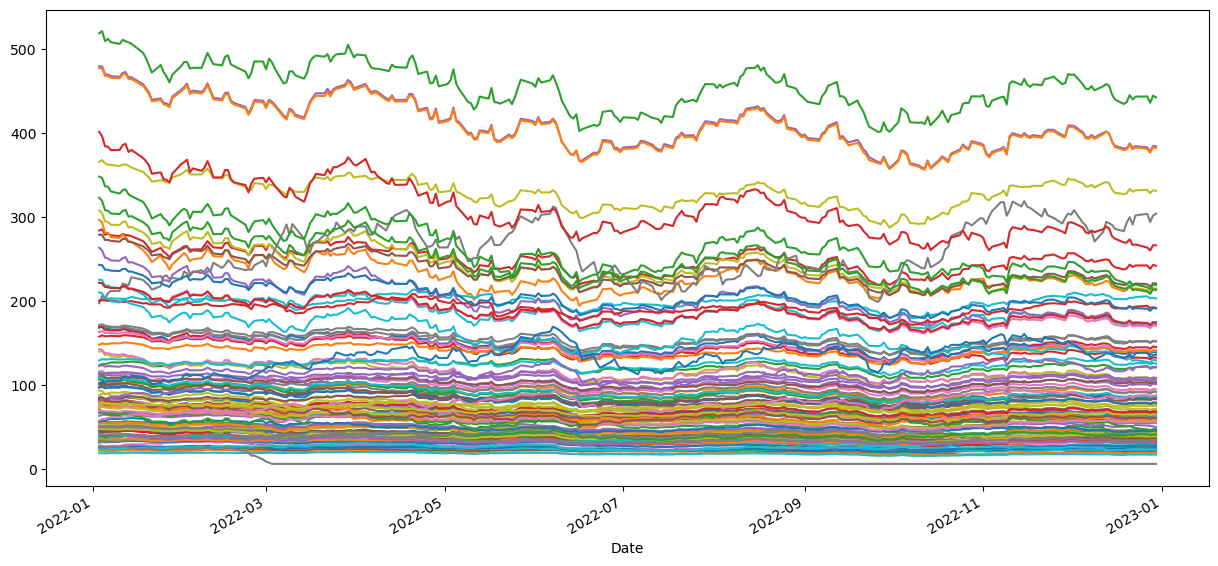

In [4]:
for i in range(close_prices.shape[1]):
    S = close_prices.iloc[:, i]
    S.plot(figsize=(15,7))

In [5]:
close_prices.shape

(251, 111)

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = {}
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs[(keys[i], keys[j])] = result
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(close_prices)

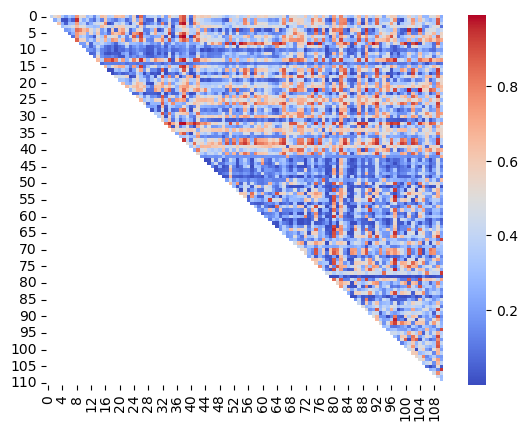

In [8]:
sns.heatmap(pvalues, cmap='coolwarm', mask=(pvalues==1))
plt.show()

In [9]:
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data[:10]

[(('PDP', 'XLF'), 1.027012503486696e-06),
 (('PDP', 'VFH'), 1.1252669785970057e-06),
 (('PDP', 'PRF'), 1.146992047447337e-06),
 (('IWO', 'KRE'), 4.376025724218153e-06),
 (('IVV', 'SPY'), 7.270774171486745e-06),
 (('IWO', 'KBE'), 7.56061351278883e-06),
 (('PDP', 'RSP'), 2.9132308142961568e-05),
 (('IWP', 'IYF'), 3.410014050716425e-05),
 (('IWP', 'XLF'), 3.878581994195884e-05),
 (('IWP', 'VFH'), 5.559979160956589e-05)]

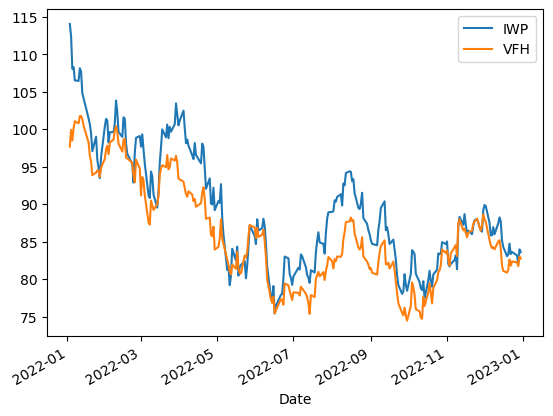

In [10]:
a, b = 'IWP', 'VFH'
pair_data = pd.DataFrame({'S1_close':close_prices[a],'S2_close':close_prices[b]
                         ,'S1_open':open_prices[a],'S2_open':open_prices[b]
                         ,'S1_high':high_prices[a],'S2_high':high_prices[b]
                         ,'S1_low':low_prices[a],'S2_low':low_prices[b]
                         ,'S1_volume':volumes[a],'S2_volume':volumes[b]})
pair_data['S1_close'].plot()
pair_data['S2_close'].plot()
plt.legend([a,b])
plt.show()

In [11]:
# 1. Momentum Indicators
# Relative Strength Index
pair_data['S1_rsi'] = ta.momentum.rsi(pair_data['S1_close'], fillna=1)
pair_data['S2_rsi'] = ta.momentum.rsi(pair_data['S2_close'],fillna=1)

# Money Flow Index
pair_data['S1_mfi'] = ta.volume.MFIIndicator(pair_data['S1_high'], pair_data['S1_low'], 
                        pair_data['S1_close'], pair_data['S1_volume'],fillna=1).money_flow_index()
pair_data['S2_mfi'] = ta.volume.MFIIndicator(pair_data['S2_high'], pair_data['S2_low'], 
                    pair_data['S2_close'], pair_data['S2_volume'],fillna=1).money_flow_index()

# 2. Volume Indicators
# Accumulation/Distribution Index (ADI)
pair_data['S1_adi'] = ta.volume.acc_dist_index(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_adi'] = ta.volume.acc_dist_index(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'], pair_data['S2_volume'])

# Volume-price trend (VPT)
pair_data['S1_vpt'] = ta.volume.volume_price_trend(pair_data['S1_close'], pair_data['S1_volume'])
pair_data['S2_vpt'] = ta.volume.volume_price_trend(pair_data['S2_close'], pair_data['S2_volume'])

# 3. Volatility Indicators
# Average True Range (ATR)
pair_data['S1_atr'] = ta.volatility.average_true_range(pair_data['S1_high'], pair_data['S1_low'], 
                                                       pair_data['S1_close'])
pair_data['S2_atr'] = ta.volatility.average_true_range(pair_data['S2_high'], pair_data['S2_low'], 
                                                       pair_data['S2_close'])

# Bollinger Bands (BB) N-period simple moving average (MA)
pair_data['S1_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S1_close'], fillna=1)
pair_data['S2_bb_ma'] = ta.volatility.bollinger_mavg(pair_data['S2_close'], fillna=1)

# 4. Trend Indicators
# Average Directional Index (ADX)
pair_data['S1_adx'] = ta.trend.adx(pair_data['S1_high'], pair_data['S1_low'], pair_data['S1_close'])
pair_data['S2_adx'] = ta.trend.adx(pair_data['S2_high'], pair_data['S2_low'], pair_data['S2_close'])

# Exponential Moving Average
pair_data['S1_ema'] = ta.trend.ema_indicator(pair_data['S1_close'], fillna=1)
pair_data['S2_ema'] = ta.trend.ema_indicator(pair_data['S2_close'], fillna=1)

# Moving Average Convergence Divergence (MACD)
pair_data['S1_macd'] = ta.trend.macd(pair_data['S1_close'], fillna=1)
pair_data['S2_macd'] = ta.trend.macd(pair_data['S2_close'], fillna=1)

# 5. Other Indicators
# Daily Log Return (DLR)
pair_data['S1_dlr'] = ta.others.daily_log_return(pair_data['S1_close'],fillna=1)
pair_data['S2_dlr'] = ta.others.daily_log_return(pair_data['S2_close'],fillna=1)

/Users/homefolder/miniconda3/lib/python3.10/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/homefolder/miniconda3/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/homefolder/miniconda3/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)
/Users/homefolder/miniconda3/lib/python3.10/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label

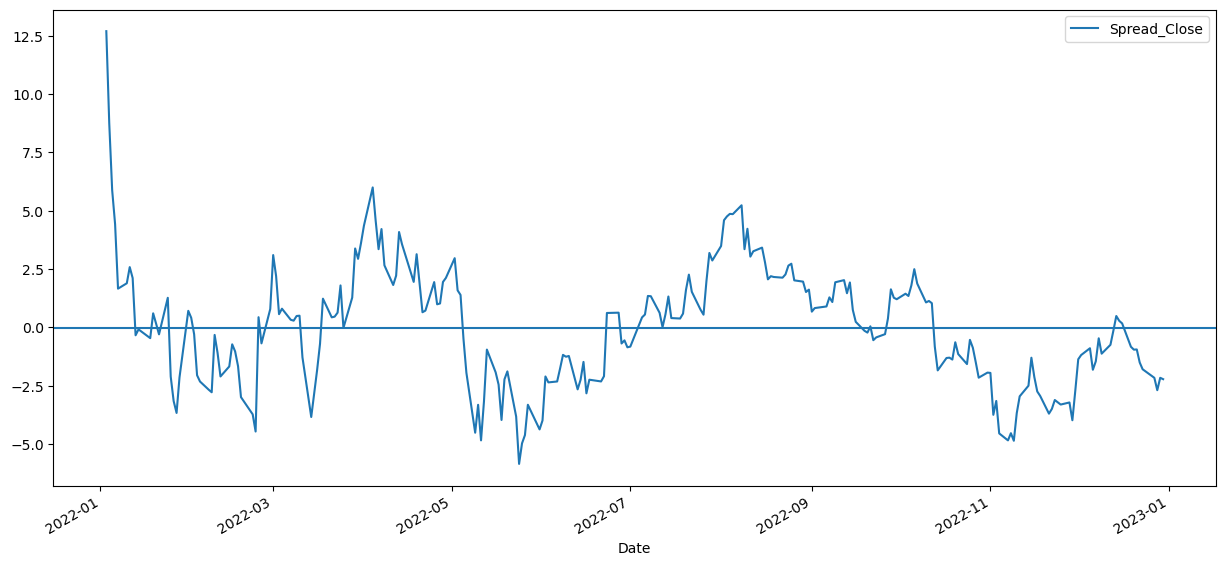

In [12]:
est = sm.OLS(pair_data.S1_close, pair_data.S2_close) # (y,x)
est = est.fit()
alpha = -est.params[0] # y = beta * x, here alpha = -beta
pair_data['Spread_Close'] = pair_data.S1_close + (pair_data.S2_close * alpha)
pair_data['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pair_data['Spread_Close'].mean())
plt.legend(['Spread_Close'])
plt.show()

In [13]:
est.params[0]

1.0374296005444097

In [14]:
est_op = sm.OLS(pair_data.S1_open, pair_data.S2_open)
est_op = est_op.fit()
alpha_op = -est_op.params[0]
pair_data['Spread_Open'] = pair_data.S1_open + (pair_data.S2_open * alpha_op)
est_hi = sm.OLS(pair_data.S1_high, pair_data.S2_high)
est_hi = est_hi.fit()
alpha_hi = -est_hi.params[0]
pair_data['Spread_High'] = pair_data.S1_high + (pair_data.S2_high * alpha_hi)
est_lo = sm.OLS(pair_data.S1_low, pair_data.S2_low)
est_lo = est_lo.fit()
alpha_lo = -est_lo.params[0]
pair_data['Spread_Low'] = pair_data.S1_low + (pair_data.S2_low * alpha_lo)

In [15]:
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
        'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
        'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
        'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pair_data = pd.DataFrame({'Spread_Close':pair_data['Spread_Close'][30:],
                               'Spread_Open':pair_data['Spread_Open'][30:],
                               'Spread_High':pair_data['Spread_High'][30:],
                               'Spread_Low':pair_data['Spread_Low'][30:],
                               'S1_volume':pair_data['S1_volume'][30:],
                               'S2_volume':pair_data['S2_volume'][30:],
                               'S1_rsi':pair_data['S1_rsi'][30:],
                               'S2_rsi':pair_data['S2_rsi'][30:],
                               'S1_mfi':pair_data['S1_mfi'][30:],
                               'S2_mfi':pair_data['S2_mfi'][30:],
                               'S1_adi':pair_data['S1_adi'][30:],
                               'S2_adi':pair_data['S2_adi'][30:],
                               'S1_vpt':pair_data['S1_vpt'][30:],
                               'S2_vpt':pair_data['S2_vpt'][30:],
                               'S1_atr':pair_data['S1_atr'][30:],
                               'S2_atr':pair_data['S2_atr'][30:],
                               'S1_bb_ma':pair_data['S1_bb_ma'][30:],
                               'S2_bb_ma':pair_data['S2_bb_ma'][30:],
                               'S1_adx':pair_data['S1_adx'][30:],
                               'S2_adx':pair_data['S2_adx'][30:],
                               'S1_ema':pair_data['S1_ema'][30:],
                               'S2_ema':pair_data['S2_ema'][30:],
                               'S1_macd':pair_data['S1_macd'][30:],
                               'S2_macd':pair_data['S2_macd'][30:],
                               'S1_dlr':pair_data['S1_dlr'][30:],
                               'S2_dlr':pair_data['S2_dlr'][30:]
                              }, columns = cols)

In [16]:
train_size = int(len(lstm_pair_data) * 0.7)
dev_size = int((len(lstm_pair_data) - train_size) * 0.5) - 3
test_size = len(lstm_pair_data) - train_size - dev_size
train, dev, test = lstm_pair_data[0:train_size], lstm_pair_data[train_size:train_size + dev_size], lstm_pair_data[train_size + dev_size:len(lstm_pair_data)]
print(len(train), len(dev), len(test))

154 30 37


In [17]:
def wav_den(ts_orig):
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    return ts_rec[1:]

train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

In [18]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
# creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

look_back = 1
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

In [19]:
from sklearn.metrics import mean_squared_error
def criterion(actual_values, predicted_values):
    return mean_squared_error(actual_values, predicted_values)
    
def normalize(series):
    return (series - np.mean(series)) / np.std(series)

In [23]:
def KalmanFilterAverage(x):
    kf = KalmanFilter(
        transition_matrices = [1],
        observation_matrices = [1],

        )
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    kf = KalmanFilter(
        transition_matrices=np.eye(1),
        observation_matrices=np.array(x).reshape(-1,1,1),

    )
    state_means, _ = kf.filter(y.values)
    return state_means

In [25]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
 
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
 
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
 
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
 
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [27]:
KalmanFilterRegression(KalmanFilterAverage(pair_data.S1_close),
        KalmanFilterAverage(pair_data.S2_close)).shape

(251, 2)

In [30]:
(beta).shape

(251, 2)

In [32]:
beta =  KalmanFilterRegression(KalmanFilterAverage(pair_data.S1_close),
        KalmanFilterAverage(pair_data.S2_close)).squeeze()
state_means = - KalmanFilterRegression(KalmanFilterAverage(pair_data.S1_close),KalmanFilterAverage(pair_data.S2_close))[:,0]
results = pair_data.S1_close + (pair_data.S2_close * state_means)
#results = pair_data.S1_close - (pair_data.S2_close * beta)
#results = KalmanFilterAverage(pair_data.S1_close) - KalmanFilterAverage(pair_data.S2_close) * beta
yhat_KF = results[-len(testX):].values 
print('MSE:', criterion(testY_untr, yhat_KF))

MSE: 25.69836238665942


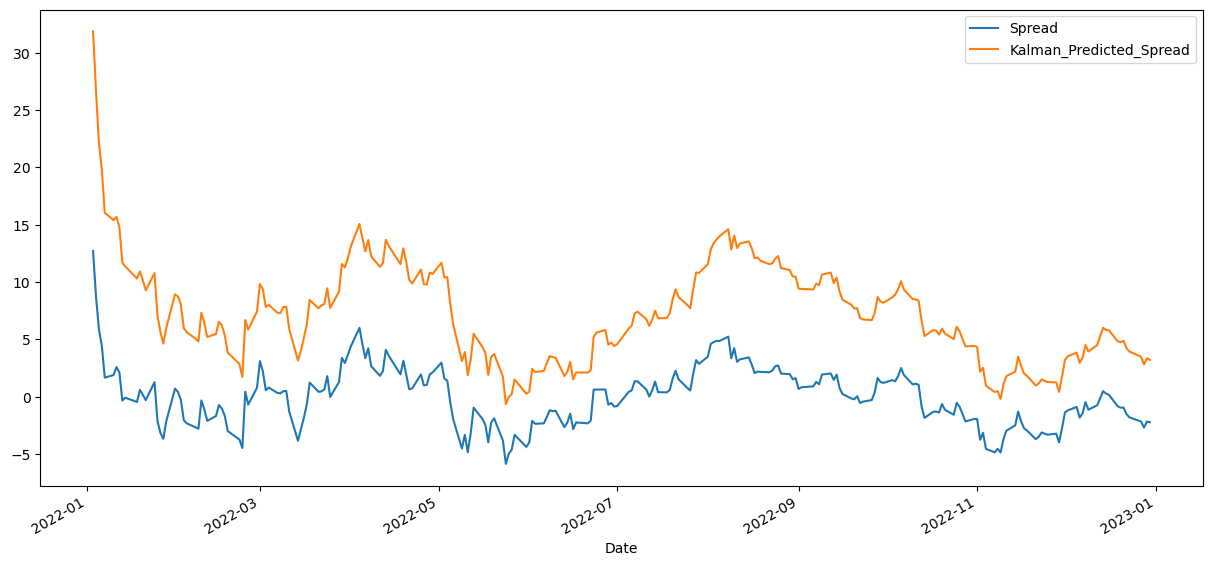

In [33]:
pair_data['Spread_Close'].plot(figsize=(15,7))
results.plot(figsize=(15,7))
plt.legend(['Spread', 'Kalman_Predicted_Spread'])
plt.show()

In [36]:
yhat_ARIMA = []
data = lstm_pair_data['Spread_Close'].values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    model = ARIMA(data[:i], order=(1,0,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=look_back)[0]
    yhat_ARIMA.append(forecast)
criterion(testY_untr, yhat_ARIMA)

0.8238709671998499

In [37]:
yhat_VAR = []
data = lstm_pair_data.values
for i in range(train_size+dev_size, len(lstm_pair_data)-1):
    df = data[:i,:]
    model = VAR(df)
    model_fit = model.fit()
    forecast = model_fit.forecast(df[-1:], steps=look_back)[:,0][0]
    yhat_VAR.append(forecast)

criterion(testY_untr, yhat_VAR)

1.1146618167909208

In [38]:
yhat_FbProphet = []
cols = ['ds', 'y']
fbData = pd.DataFrame({'ds':lstm_pair_data.index, 'y':lstm_pair_data.Spread_Close}, columns = cols)
for i in range(train_size+dev_size+1, len(lstm_pair_data)):
    model = Prophet()
    model.fit(fbData[:i])
    future = model.make_future_dataframe(periods=look_back)
    forecast = (model.predict(future)).yhat[i:].values
    yhat_FbProphet.append(forecast[0])
criterion(testY_untr, yhat_FbProphet)

14:10:20 - cmdstanpy - INFO - Chain [1] start processing
14:10:20 - cmdstanpy - INFO - Chain [1] done processing
14:10:20 - cmdstanpy - INFO - Chain [1] start processing
14:10:20 - cmdstanpy - INFO - Chain [1] done processing
14:10:20 - cmdstanpy - INFO - Chain [1] start processing
14:10:20 - cmdstanpy - INFO - Chain [1] done processing
14:10:20 - cmdstanpy - INFO - Chain [1] start processing
14:10:20 - cmdstanpy - INFO - Chain [1] done processing
14:10:20 - cmdstanpy - INFO - Chain [1] start processing
14:10:20 - cmdstanpy - INFO - Chain [1] done processing
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1]

3.5626257436798543

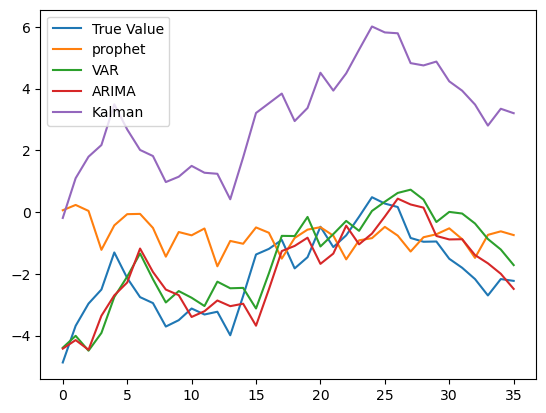

In [39]:
plt.plot(testY_untr, label='True Value')
plt.plot(yhat_FbProphet, label='prophet')
plt.plot(yhat_VAR, label='VAR')
plt.plot(yhat_ARIMA, label='ARIMA')
plt.plot(yhat_KF, label='Kalman')
plt.legend()
plt.show()

In [34]:
import torch
X_train = torch.tensor(np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])), dtype=torch.float32)
X_valid = torch.tensor(np.reshape(devX, (devX.shape[0], 1, devX.shape[1])), dtype=torch.float32)
X_test = torch.tensor(np.reshape(testX, (testX.shape[0], 1, testX.shape[1])), dtype=torch.float32)
y_train = torch.tensor(trainY, dtype=torch.float32)
y_test = torch.tensor(testY, dtype=torch.float32)

In [35]:
y_train.dtype

torch.float32

In [36]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take only the output from the last timestep
        return out

In [64]:
input_size = 26
hidden_size = 64
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
    with torch.no_grad():
        if epoch % 10 == 0:
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            print(f'Test loss: {test_loss.item():.4f}')

# Forecast one step ahead
last_observation = X_test[-1].unsqueeze(0)  # Use the last observation as input
predicted_value = model(last_observation).item()

print(f'Predicted value for the next step: {predicted_value:.4f}')

Epoch [1/1000], Loss: 0.3686
Test loss: 0.3670
Epoch [11/1000], Loss: 0.1799
Test loss: 0.1837
Epoch [21/1000], Loss: 0.0556
Test loss: 0.0797
Epoch [31/1000], Loss: 0.0309
Test loss: 0.0839
Epoch [41/1000], Loss: 0.0311
Test loss: 0.0829
Epoch [51/1000], Loss: 0.0231
Test loss: 0.0683
Epoch [61/1000], Loss: 0.0216
Test loss: 0.0654
Epoch [71/1000], Loss: 0.0190
Test loss: 0.0647
Epoch [81/1000], Loss: 0.0174
Test loss: 0.0636
Epoch [91/1000], Loss: 0.0160
Test loss: 0.0606
Epoch [101/1000], Loss: 0.0149
Test loss: 0.0578
Epoch [111/1000], Loss: 0.0140
Test loss: 0.0554
Epoch [121/1000], Loss: 0.0132
Test loss: 0.0526
Epoch [131/1000], Loss: 0.0125
Test loss: 0.0497
Epoch [141/1000], Loss: 0.0120
Test loss: 0.0467
Epoch [151/1000], Loss: 0.0115
Test loss: 0.0438
Epoch [161/1000], Loss: 0.0110
Test loss: 0.0409
Epoch [171/1000], Loss: 0.0106
Test loss: 0.0381
Epoch [181/1000], Loss: 0.0102
Test loss: 0.0354
Epoch [191/1000], Loss: 0.0099
Test loss: 0.0329
Epoch [201/1000], Loss: 0.0095


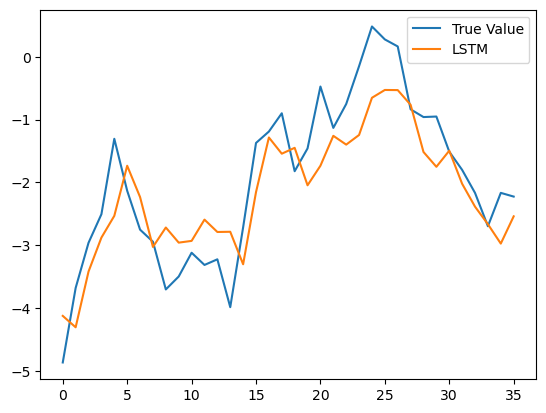

In [65]:
yhat = model(X_test).detach().numpy()
plt.plot(testY_untr, label='True Value')
plt.plot(scaler.inverse_transform(yhat), label='LSTM')
plt.legend()
plt.show()

In [40]:
def trade(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * 1.04
            countS1 -= 1
            countS2 += 1.03
        # Buy long if the z-score is < 1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * 1.04
            countS1 += 1
            countS2 -= 1.03
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] - S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [44]:
test_data['Kalman_Predicted_Spread'] = [0] + list(yhat_KF[1:]) 

In [56]:
test_data = pd.DataFrame({'S1':pair_data['S1_close'].iloc[-len(testX):],'S2':pair_data['S2_close'].iloc[-len(testX):]})
test_data['Actual_Spread'] = pair_data['Spread_Close'].iloc[-len(testX):]
test_data['Kalman_Predicted_Spread']  = yhat_KF
test_data['Kalman_Predicted_Spread'] = [0]*5 + list(yhat_KF[5:]) 
test_data['ARIMA_Predicted_Spread']  = yhat_ARIMA
test_data['VAR_Predicted_Spread']  = yhat_VAR
test_data['FBProphet_Predicted_Spread']  = yhat_FbProphet
w1, w2 = 5, 12
print('true:', trade(test_data['S1'], test_data['S2'], test_data['Actual_Spread'], w1, w2))
print('Kalman:', trade(test_data['S1'], test_data['S2'], test_data['Kalman_Predicted_Spread'],  w1, w2))
print('ARIMA:',trade(test_data['S1'], test_data['S2'], test_data['ARIMA_Predicted_Spread'],  w1, w2))
print('VAR:',trade(test_data['S1'], test_data['S2'], test_data['VAR_Predicted_Spread'],  w1, w2))
print('Prophet',trade(test_data['S1'], test_data['S2'], test_data['FBProphet_Predicted_Spread'],  w1, w2))

true: 171.47329711914062
Kalman: 169.23899810791016
ARIMA: 169.7579002380371
VAR: 339.33620086669924
Prophet 0.0


In [85]:
test_data['LSTM'] = scaler.inverse_transform(yhat)
print('LSTM',trade(test_data['S1'], test_data['S2'], 
test_data['LSTM'],  w1, w2))

LSTM 341.9609963989258
